
### Предисловие

С размышлениями и оформлением это решение я написал за ~14 часов.

Я начал с того что погуглил, и перейдя по первой ссылке нашёл <a href="https://www.researchgate.net/publication/319037859_Classification_of_Male_and_Female_Speech_Using_Perceptual_Features ">вот такую статью</a>. Понятно, что моя задача более игрушечная (всего 200 семплов во всём датасете), и вряд ли мне требуется слово в слово реализовать то, что здесь описано, но отсюда я почерпнул две вещи: две фичи и классификаторы (SVM и KNN).

Заранее скажу, что лучшая модель получает значение макро f-меры в районе ~0.83 на тесте (значение меняется на +- -0.03 при изменении random_state при train_test_split. При этом я вообще не использую преобразование Фурье -- просто я решил, что этого результата достаточно если мне просто нужно показать что я умею в мешин лёрнинг. Если ожидается результат лучше -- я могу накидать ещё признаков через амплитуду и магспек, уверен результаты станут лучше.

### 1.  Preprocessing

Для начала разделим данные на трейн и тест таким образом, чтоб соотношение male/female было для них одинаковым:

In [1]:
import os
import numpy as np

from sklearn.model_selection import train_test_split


filenames = sorted(os.listdir('./wav_data'))
with open('m.txt', 'r') as f:
    male_filenames = f.read().split('\n')[:-1] # [:-1] чтоб убрать пустую строку, т.к. в конце файла \n
target = [int(filename in male_filenames) for filename in filenames]

train_filenames, test_filenames, y_train, y_test = train_test_split(filenames, 
                                                                    target, 
                                                                    test_size = 0.2, 
                                                                    stratify=target,
                                                                   random_state = 239)
print('Кол-во семплов в трейне: {}'.format(len(train_filenames)))
print('Кол-во семплов в тесте: {}'.format(len(test_filenames)))
print('Мужских семплов в трейне: {}'.format(np.sum(y_train)))
print('Мужских семплов в тесте: {}'.format(np.sum(y_test)))

Кол-во семплов в трейне: 163
Кол-во семплов в тесте: 41
Мужских семплов в трейне: 82
Мужских семплов в тесте: 20


Теперь давайте прочитаем файлы, переведём их в числа и для примера нарисуем случайный файл.

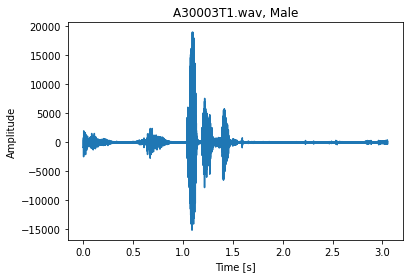

In [2]:
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
import random


def filename_to_wav(filename, plot_wav = False):
    path_to_wav = './wav_data/' + filename
    sample_rate, audio_buffer = scipy.io.wavfile.read(path_to_wav)
    
    if(plot_wav):
        duration = len(audio_buffer)/sample_rate

        time = np.arange(0, duration, 1/sample_rate) #time vector

        plt.plot(time,audio_buffer)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        
        label = 'Male' if filename in male_filenames else 'Female'
        
        plt.title('{}, {}'.format(filename, label))
        plt.show()
    
    return audio_buffer


random_wav_id = random.randint(0, len(filenames) - 1)
random_filename = filenames[random_wav_id]
random_audio_buffer = filename_to_wav(random_filename, plot_wav=True)
train_wav = np.array(list(map(filename_to_wav, train_filenames)))
test_wav = np.array(list(map(filename_to_wav, test_filenames)))

Теперь давайте кадрируем данные. Размер окна и сдвиг взяты из статьи.

In [3]:
WIN_SHIFT = 25
WIN_SIZE = 50


def wav_to_frames(wav):
    num_frames = int(np.floor((wav.shape[0] - WIN_SIZE) / WIN_SHIFT) + 1)
    frames = np.zeros([WIN_SIZE, num_frames])
    for t in range(0, num_frames):
        frame = wav[t * WIN_SHIFT:t * WIN_SHIFT + WIN_SIZE]
        frame = frame - np.mean(frame)
        frames[:, t] = np.hamming(WIN_SIZE) * frame
    return frames.T

random_frame = wav_to_frames(random_audio_buffer)
train_frames = np.array(list(map(wav_to_frames, train_wav)))
test_frames = np.array(list(map(wav_to_frames, test_wav)))

### 2. Извлечение признаков



#### 1) Short Time Zero Crossing Rate (STZCR)

Этот признак показывает как часто аудиосигнал одного кадра (фрейма) меняет свой знак. В качестве признака для одного семпла из исходного датасета возьмем среднее значение и отклонение этого признака по всем кадрам фрейма.

In [4]:
def get_zcr(framed_wav):
    n_frames, n_feat = framed_wav.shape
    zcr = np.zeros(n_frames)
    
    #я знаю что следующие три строчки стоило бы записать в одну, но могу так только в pandas
    for i in range(n_frames):
        for j in range(1, n_feat):
            zcr[i] = zcr[i] + np.sign(framed_wav[i][j - 1] * framed_wav[i][j])
    return np.mean(zcr), np.std(zcr)

train_zcr = np.array(list(map(get_zcr, train_frames)))

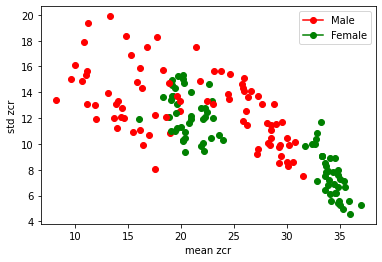

In [5]:
import matplotlib.lines as mlines

handles = [mlines.Line2D([], [], color='red', marker='o', label='Male'),
           mlines.Line2D([], [], color='green', marker='o', label='Female')]

plt.xlabel('mean zcr')
plt.ylabel('std zcr')


for i in range(len(train_zcr)):
    label = 'ro' if y_train[i] == 1 else 'go'
    plt.plot(train_zcr[i][0], train_zcr[i][1], label)    

plt.legend(handles=handles)

plt.show()

Ура, чисто визуально данные вполне разделимы уже по этому одному (двум признакам). Давайте извлечём еще один (два).

#### 2) Short Time Energy (STE)

Этот признак характеризует динамику изменения сигнала. Точно так же -- посчитаем его для каждого фрейма, а в качестве признаков возьмем среднее и стандартное отклонение.

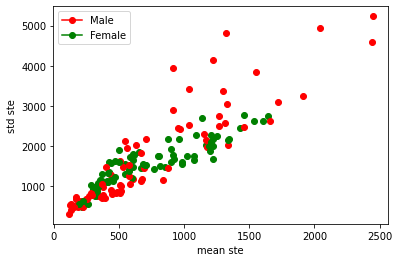

In [6]:
#вот так, в лоб, я считаю амплитуду без преобразования фурье
def get_amplitude(sample):
    max_val = np.max(sample)
    min_val = np.min(sample)
    mean_val = np.mean(sample)
    return max(max_val - mean_val, mean_val - min_val)

def get_ste(framed_wav):
    amplitudes = np.array(list(map(get_amplitude, framed_wav)))
    return amplitudes.mean(), amplitudes.std()

train_ste = np.array(list(map(get_ste, train_frames)))

plt.xlabel('mean ste')
plt.ylabel('std ste')


for i in range(len(train_zcr)):
    label = 'ro' if y_train[i] == 1 else 'go'
    plt.plot(train_ste[i][0], train_ste[i][1], label)    

plt.legend(handles=handles)

plt.show()

Пока что остановимся. Получим таблицу фичей.

In [26]:
import pandas as pd

def extract_features(framed_wavs, labels):
    
    result_table = pd.DataFrame(index=['zcr mean', 'zcr std',
                                       'ste mean', 'ste std',
                                       'target'])
    for i, (wav, label) in enumerate(zip(framed_wavs, labels)):
        zcr_m, zcr_s = get_zcr(wav)
        ste_m, ste_s = get_ste(wav)
        result_table[train_filenames[i]] = [zcr_m, zcr_s, ste_m, ste_s, label]
        
    return result_table.T
        
train_data = extract_features(train_frames, y_train)
train_data

,zcr mean,zcr std,ste mean,ste std,target
A30001X4.wav,29.245128,9.795259,134.266853,395.581364,1.0
A30003A1.wav,13.850112,13.079601,628.478485,2025.228578,1.0
A30001S2.wav,28.448517,11.451473,436.945973,896.189866,1.0
A30003A4.wav,19.947907,12.561850,545.960565,2136.898722,1.0
A30002L3.wav,19.068147,13.409153,1168.654399,2028.283803,0.0
...,...,...,...,...,...
A30001C3.wav,21.450996,17.526612,675.561974,1166.982307,1.0
A30001L2.wav,26.166723,12.558975,378.569868,779.966677,1.0
A30000M1.wav,34.015070,8.911615,1203.042356,1872.101406,0.0
A30001A5.wav,28.213925,10.033076,154.618235,479.928108,1.0


### 3. Применение моделей

Для начала доведём до ума данные. Во-первых, давайте стандартизуем данные, а во-вторых -- давайте примением метод главных компонент и сократим число признаков до двух. Это нужно для визуализации, но забегая вперёд скажу, что для простоты я применяю модели к сокращенным до двух измерений данным.

In [27]:
import copy

def standartize_table(table, source_table):
    
    #table -- таблица которую хотим преобразовать
    #source_table -- таблица, на основе которой хотим преобразовать table. И для трейна, и для теста
    # этой таблицей будет служить train, ну классика короче
    
    for col in source_table.columns:
        table[col] = (table[col] - source_table[col].mean()) / source_table[col].std() 
    return table

from sklearn.decomposition import PCA

train_data = train_data.drop(['target'], axis=1)
X = standartize_table(copy.copy(train_data), train_data)
pca = PCA(n_components = 2)
pca.fit(X)
X_pca = pca.transform(X)

m0_filename = 'pca.sav'
pickle.dump(pca, open(m0_filename, 'wb'))
train_data.to_pickle('source_table.pkl')

Преобразуем также и тестовые данные

In [9]:
test_features = extract_features(test_frames, y_test).drop(['target'], axis = 1)
test_features = standartize_table(test_features, train_data)
test_pca = pca.transform(test_features)

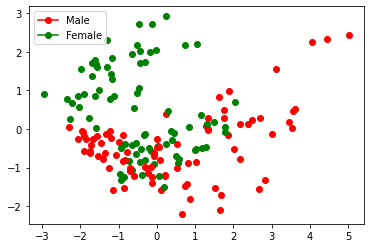

In [10]:
for i in range(len(X_pca)):
    label = 'ro' if y_train[i] == 1 else 'go'
    plt.plot(X_pca[i][0], X_pca[i][1], label)    

plt.legend(handles=handles)

plt.show()

#### 1) Support Vector Machine (Метод Опорных Векторов)

SVM решает задачу бинарной классификации в n-мерной пространстве построение (n-1)-мерной разделяющей плоскости -- то что нужно. Правда, на картинке выше видно, что данные не очень делятся прямой, но это ничего потому что существуют ядерные преобразования. 

С помощью grid search, выполняющего 5-фолдовую кросс-валидацию давайте найдем лучшие значения параметров SVM по макро f1-мере (невзвешенное среднее между бинарной f1-мерой по каждому из классов). Переберём параметры регурялизации, ядра для ядерного преобразования и коэфициент гамма при ядре (для нелинейных преобразований).

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()


svm_params = {
    'C': [0.1, 0.4, 0.7, 0.9, 1.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

clf = GridSearchCV(svm, svm_params,
                  scoring = 'f1_micro',
                  cv = 5)

clf.fit(X_pca, y_train)

svm_best_params = clf.best_params_
svm_best_params

{'C': 0.7, 'gamma': 'auto', 'kernel': 'rbf'}

#### 2) KNN Classifier

Этот классификатор работает принципиально по другому -- он предсказывает лейбл объекта в зависимости от лейблов его K ближайших соседей. Сделаем точно такой же поиск лучших параметров. Перебирать будем количество соседей K, значимость расстояния до ближайшего соседа (имеет ли значение как далеко сосед, и если да -- то чем ближе сосед, тем больше предсказание будет склоняться к лейблу соседа) и метрику расстояния (минковского / эвклидово).

In [12]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 20, 25, 37, 50],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

clf = GridSearchCV(knn, knn_params,
                  scoring = 'f1_micro',
                  cv = 5)

clf.fit(X_pca, y_train)

knn_best_params = clf.best_params_
knn_best_params

{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}

Теперь давайте передадим обеим моделям лучшие параметры и проверим их точность на тестовом множестве.

In [13]:
from sklearn.metrics import f1_score
import pickle 

def print_model_results(model, model_name):

    test_pred = model.predict(test_pca)
    
    print("{} results:".format(model_name))

    print("\tf1 score on Male class = {:.3f}".format(f1_score(y_test, test_pred, pos_label = 1)))
    print("\tf1 score on Female class = {:.3f}".format(f1_score(y_test, test_pred, pos_label = 0)))

    test_len = len(y_test)
    print("\tAccuracy = {:.3f}".format(sum([1 if y_test[i] == test_pred[i] else 0 for i in range(test_len)]) / test_len))

    
svm = SVC(**svm_best_params)
svm.fit(X_pca, y_train)
pickle.

knn = KNeighborsClassifier(**knn_best_params)
knn.fit(X_pca, y_train)

print_model_results(svm, 'Support Vector Classifier')
print_model_results(knn, 'K-Neighbors Classifier')

Support Vector Classifier results:
	f1 score on Male class = 0.857
	f1 score on Female class = 0.850
	Accuracy = 0.854
K-Neighbors Classifier results:
	f1 score on Male class = 0.829
	f1 score on Female class = 0.829
	Accuracy = 0.829


Даже с учетом того, что монетка даёт точность 0.5 -- числа вполне приличные.